# Лаб. №3: анализ исторической вспышки холеры в Лондоне


In [51]:

import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np

### Шаг 1.1 Изучаем исходные данные


In [3]:
cholera_cases = gpd.read_file('data/Cholera_deaths_ll.shp')

pumps = gpd.read_file('data/Pumps_ll.shp')


In [4]:
cholera_cases.explore(color='red', tiles='cartodbpositron') # Слой холеры


In [5]:
pumps.explore(color='blue', tiles='cartodbpositron')  # Слой насосных станций

### Шаг 1.2 Изучите данные


Какие атрибуты они содержат? На основе данных посчитайте, сколько смертей от холеры было зафиксировано в этом районе.


In [8]:
cholera_cases

,OBJECTID,Id,Count,Streetname,Xcoord,Ycoord,geometry
0,1,1,3,Marshall St,-0.137813,51.513414,POINT (-0.13781 51.51341)
1,2,2,2,Marshall St,-0.137806,51.513358,POINT (-0.13781 51.51336)
2,3,3,1,Marshall St,-0.137759,51.513292,POINT (-0.13776 51.51329)
3,4,4,1,Marshall St,-0.137728,51.513242,POINT (-0.13773 51.51324)
4,5,5,4,Marshall St,-0.137661,51.513190,POINT (-0.13766 51.51319)
...,...,...,...,...,...,...,...
308,309,309,1,Pulteney Court,-0.135732,51.513051,POINT (-0.13573 51.51305)
309,310,310,1,Marlborough Row,-0.138114,51.512930,POINT (-0.13811 51.51293)
310,311,311,2,Marlborough Row,-0.138171,51.512989,POINT (-0.13817 51.51299)
311,312,312,1,Cross St,-0.138837,51.512992,POINT (-0.13884 51.51299)


# Количество смертей в районе

In [10]:
cholera_cases['Count'].sum()

569

In [25]:
cholera_cases[['Streetname', 'Count']].groupby(['Streetname']).sum().reset_index().sort_values(by=['Count'], ascending=False).head()

,Streetname,Count
5,Broad St,89
3,Berwick St,48
32,Marshall St,40
40,Poland St,26
49,St Anns Court,25


### Шаг 2.1 Плотность точек


Вычислите плотность точек со случаями холеры по ячейкам регулярной сетки. Отобразите значения на карте.


In [20]:
import osmnx as ox

area = ox.geocode_to_gdf('Soho, London')
utm = cholera_cases.estimate_utm_crs()
admin_district_utm = area.to_crs(utm)

In [22]:
# Получаем границы
total_bounds = admin_district_utm.total_bounds

In [23]:
minX, minY, maxX, maxY = total_bounds

In [ ]:
from shapely.geometry import Polygon

SQUARE_SIZE = 150

def get_grid(gdf, square_size):
    utm_zone = gdf.estimate_utm_crs()
    gdf = gdf.to_crs(utm_zone)
    minX, minY, maxX, maxY = gdf.total_bounds
    
    grid_cells = []
    x, y = minX, minY

    while y <= maxY:
        while x <= maxX:
            geom = Polygon([
                (x, y), 
                (x, y + square_size), 
                (x + square_size, y + square_size), 
                (x + square_size, y), 
                (x, y)
            ])
            grid_cells.append(geom)
            x += square_size
        x = minX
        y += square_size

    return gpd.GeoDataFrame(geometry=grid_cells, crs=utm_zone)

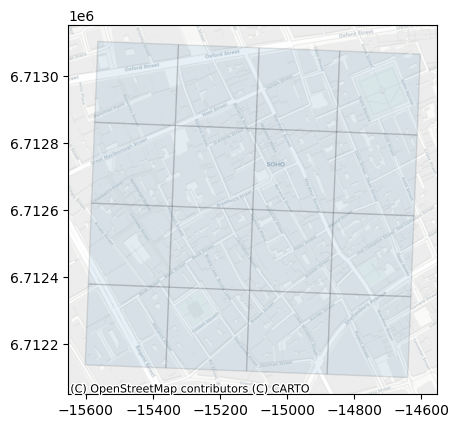

In [31]:
grid = get_grid(cholera_cases, SQUARE_SIZE)
grid.reset_index(inplace=True)

grid_3857 = grid.to_crs('EPSG:3857')

ax = grid_3857.plot(alpha=0.1, edgecolor='k')

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

plt.show()

In [35]:
cholera_grid = gpd.sjoin(cholera_cases.to_crs(grid.crs), grid, predicate='within')
cholera_grouped = cholera_grid.groupby('index_right').size()
cholera_grouped.reset_index()

,index_right,0
0,0,4
1,1,2
2,2,4
3,3,3
4,4,33
5,5,77
6,6,46
7,7,4
8,8,20
9,9,45


In [38]:
cholera_df = cholera_grouped.reset_index(name='cholera_cases')

In [41]:
cholera_count = grid.merge(cholera_df, left_on='index', right_on='index_right', how='left')

In [42]:
cholera_count.explore(column='cholera_cases', cmap='YlGnBu', tiles='cartodbpositron')

### Шаг 2.2 Плотность смертельных случаев


Рассчитайте плотность смертельных случаев в каждой ячейке регулярной сетки. Отобразите значения на карте.


In [47]:
cholera_in_cells_df = cholera_grid.groupby('index_right').agg({'Id':'count', 'Count':'sum'}).reset_index()
cholera_in_cells_df

,index_right,Id,Count
0,0,4,6
1,1,2,6
2,2,4,10
3,3,3,3
4,4,33,59
5,5,77,142
6,6,46,86
7,7,4,5
8,8,20,34
9,9,45,95


In [49]:
cholera_sum = grid.merge(cholera_in_cells_df, left_on='index', right_on='index_right', how='left')
cholera_sum.explore(column='Count', cmap='YlGnBu', tiles='cartodbpositron')

### Шаг 2.3 Опишите полученные результаты из 2.1 и 2.2


Какие интересные закономерности можно наблюдать?


Можно заметить, что наибольшая смертность в центре района.

### Шаг 3. Диаграмма Вороного


Постройте диаграмму Вороного для гидрантов. Отобразите ее на карте


In [50]:
points = pumps.geometry.centroid
points = gpd.GeoDataFrame(points, columns=['geometry'])
points.explore(tiles='cartodbpositron')

C:\Users\satae\AppData\Local\Temp\ipykernel_20912\4238153638.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  points = pumps.geometry.centroid


In [55]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
from scipy.spatial import Voronoi

# Перепроецируем точки в подходящую UTM зону
utm_zone = points.estimate_utm_crs()
pumps_points_utm = points.to_crs(utm_zone)
# Извлекаем координаты
pumps_coords = np.array([point.coords[0] for point in pumps_points_utm.geometry])
#  Строим диаграмму Вороного
vor = Voronoi(pumps_coords)
# Создаем полигоны Вороного, игнорируя бесконечные регионы
polygons = [
    Polygon([vor.vertices[i] for i in region])
    for region in vor.regions
    if region and -1 not in region
]
# Преобразуем полигоны в GeoDataFrame
voronoi_gdf = gpd.GeoDataFrame(geometry=polygons, crs=utm_zone)
# Визуализируем результат
voronoi_gdf.explore(tiles='cartodbpositron')

### Шаг 4. Количество смертельных случаев в зоне близости от каждого гидранта


Рассчитайте количество смертельных случаев в зоне влияния каждого гидранта (на основе диаграммы Вороного). Отобразите значения на карте для каждого из колодцев.Рядом с каким гидрантом произошло было зафиксировано больше всего смертельных случаев от холеры


In [62]:
voronoi_gdf.sample()

,geometry
2,"POLYGON ((698341.441 5710633.997, 694409.189 5..."


In [63]:
cholera_cases_utm = cholera_cases.to_crs(voronoi_gdf.crs)
cholera_in_pump = gpd.sjoin(cholera_cases_utm, voronoi_gdf, predicate='within')
cholera_grouped = cholera_in_pump.groupby(['index_right']).agg({'Count':'sum'})
voronoi_pump_cases = voronoi_gdf.join(cholera_grouped)

In [64]:
voronoi_pump_cases.explore(column="Count", tiles='cartodbpositron')

### Шаг 5. Nearest Neihbour Index


Как распределены точки с зафиксированной смертностью внутри района? Постройте гистограмму распределения расстояний до ближайшего соседа.
Рассчитайте Nearest Neighbour Index. Интерпретируйте результат.


In [68]:
from scipy.spatial.distance import cdist

# Вычисление расстояний между случаями холеры (матрица расстояний)
cholera_coords = np.array([point.coords[0] for point in cholera_cases_utm.geometry])
dist_matrix = cdist(cholera_coords, cholera_coords, metric="euclidean")

# Находим расстояния до ближайшего соседа, исключая расстояния до самого себя
max_distance = np.max(dist_matrix)
nearest_distances = np.min(dist_matrix + np.eye(len(dist_matrix)) * max_distance, axis=1)

# Вычисление среднего расстояния до ближайшего соседа
mean_nearest_distance = np.mean(nearest_distances)

# Вычисление площади района Сохо
soho_polygon = ox.geocode_to_gdf("Soho, London")
soho_polygon = soho_polygon.to_crs(soho_polygon.estimate_utm_crs())
soho_area = soho_polygon.area.values[0]

# Расчет ожидаемого среднего расстояния для случайного распределения точек
n_points = len(cholera_coords)
expected_mean_distance = 0.5 * np.sqrt(soho_area / n_points)

# Вычисление Индекса Ближайшего Соседа (NNI)
NNI = mean_nearest_distance / expected_mean_distance

# Результат
NNI

0.6704507920394047

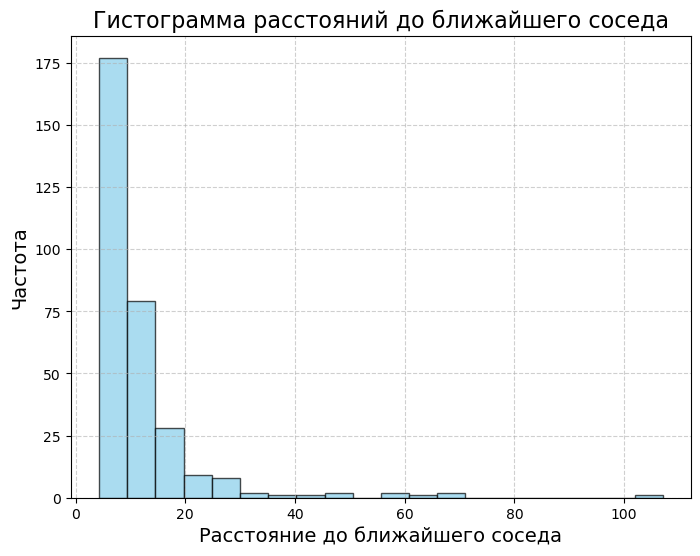

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(nearest_distances, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Гистограмма расстояний до ближайшего соседа', fontsize=16)
plt.xlabel('Расстояние до ближайшего соседа', fontsize=14)
plt.ylabel('Частота', fontsize=14)

plt.grid(visible=True, linestyle='--', alpha=0.6)

plt.show()

### Шаг 6. Подведите итог


Какие выводы можно сделать на основе проделанного анализа? Какие ограничения имеют применённые методы? С какими проблемами вы столкнулись? Какие другие методы или подходы можно использовать для уточнения анализа?


Скорее всего, в OpenStreetMap используется современная карта Лондона, а полученные данные отражают заболеваемость на более старых границах города.

Если бы в данных была информация о смертности от холеры в разных районах Лондона, то можно было бы посчитать плотность не внутри сетки, а внутри районов и сделать более информативные выводы.
